##  Importação bibliotecas

In [1]:
import pandas as pd
import utente

import importlib as imp
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Configurações

In [2]:
pd.options.display.max_columns = 100

## Carregamento dos dados

Em máquina Windows ocorre regularmente "Memory Error", provavelmente devido a algumas variáveis que não são limpas ou à cache do servidor do Jupyter. <br>
Um **fix** temporário (se não tivermos o ficheiro local PICKLE) pode ser:
1. Carregar utente.ListaUtentes com forceFetch = True <br>
2. Guardar localmente estrutura objectos em ficheiro PICKLE com output2FileHistoricosTodosUtentes() <br>
3. Fechar e voltar a abrir o Notebook <br>
4. Carregar utente.ListaUtentes com forceFetch = False <br> 
5. Carregar o Pandas Dataframe com pd.DataFrame(listaUtentes.generateDataset()) 

In [3]:
# Opcional: Reload módulo utente
imp.reload(sys.modules['utente']);

In [4]:
# Carregamento estrutura dados (passar parâmetro forceFetch = True para forçar leitura BD >> Demorado!)
#listaUtentes = utente.ListaUtentes(forceFetch = True) # Carrega dados a partir de MySQDB e guarda localmente (PICKLE)
listaUtentes = utente.ListaUtentes(forceFetch = True) # Carrega dados locais a partir de PICKLE

Criar ligação MySQL
Parsing da tabela pedidos_inscritos_longos... (1/7)
Parsing das Anulacoes... (2/7)
Total de 4109 (3%) utentes existentes em sie_31 mas sem equivalencia na pedidos_inscritos_longos:
Parse das Intervenções... (3/7)
Total de 20285 (4%) utentes existentes em sie_35 mas sem equivalencia na pedidos_inscritos_longos:
Parse dos Encaminhamentos... (4/7)
Total de 9761 (7%) utentes existentes em sie_36 mas sem equivalencia na pedidos_inscritos_longos:
Parse dos Apresentações... (5/7)
Total de 4217 (2%) utentes existentes em pd_sie_37 mas sem equivalencia na pedidos_inscritos_longos:
Parse das Convocatórias... (6/7)
Total de 11899 (4%) utentes existentes em pd_sie_38 mas sem equivalencia na pedidos_inscritos_longos:
Parse das Mudanças de Categoria... (7/7)
Total de 7052 (5%) utentes existentes em pd_sie_43 mas sem equivalencia na pedidos_inscritos_longos:
Finalizado com Sucesso!


In [25]:
listaUtentes.save()

Saving to ./temp/ListaUtentes.pickle


MemoryError: 

In [24]:
del np
del norm
del StandardScaler
del stats

In [20]:
locals()

{'In': ['',
  "import pandas as pd\nimport utente\n\nimport importlib as imp\nimport sys\n\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\nfrom scipy.stats import norm\nfrom sklearn.preprocessing import StandardScaler\nfrom scipy import stats\nimport warnings\nwarnings.filterwarnings('ignore')\nget_ipython().run_line_magic('matplotlib', 'inline')",
  'pd.options.display.max_columns = 100',
  "# Opcional: Reload módulo utente\nimp.reload(sys.modules['utente']);",
  '# Carregamento estrutura dados (passar parâmetro forceFetch = True para forçar leitura BD >> Demorado!)\n#listaUtentes = utente.ListaUtentes(forceFetch = True) # Carrega dados a partir de MySQDB e guarda localmente (PICKLE)\nlistaUtentes = utente.ListaUtentes(forceFetch = True) # Carrega dados locais a partir de PICKLE',
  'listaUtentes.save()',
  'dir()',
  'pd=None',
  'dir()',
  'globals()',
  'for var, obj in locals().items():\n    print var, sys.getsizeof(obj)',
  'for var, obj in locals().i

In [8]:
# Opcional: Output do Histórico de todos Utentes para txt >> Demorado!
listaUtentes.output2FileHistoricosTodosUtentes()

In [18]:
# Criação do dataframe pandas
df = pd.DataFrame(listaUtentes.generateDataset())
listaUtentes = None # Limpa listaUtentes depois de gerar Dataset

In [19]:
# Truncar column names a 64 caracteres e substituir caracteres acentuados
import unidecode
oldColNames = [col for col in df]
newColNames = [unidecode.unidecode((col))[:64] for col in df ]

df.rename(columns=dict(zip(oldColNames, newColNames)), inplace=True)

In [20]:
from sqlalchemy import create_engine
PASSWORD_FILENAME = './password.txt'
with open(PASSWORD_FILENAME) as f: mysqlpass = f.read()
engine = create_engine('mysql+pymysql://grupo_1:{}@151.236.42.86:3306/iefp'.format(mysqlpass))

In [17]:
df.to_sql('DatasetModelo', engine, if_exists='replace')

OperationalError: (pymysql.err.OperationalError) (1142, "CREATE command denied to user 'grupo_1'@'62.28.228.26' for table 'datasetmodelo'") [SQL: '\nCREATE TABLE `DatasetModelo` (\n\t`index` BIGINT, \n\t`ConjugeMotivoIndisponibilidade` TEXT, \n\t`Data` TEXT, \n\t`DataNascimento` TEXT, \n\t`DiasDesemprego` TEXT, \n\t`Empregado` TEXT, \n\t`EstadoCivil` TEXT, \n\t`LTU` TEXT, \n\t`Nacionalidade` TEXT, \n\t`NivelDeficiencia` TEXT, \n\t`NrAnulacoes` TEXT, \n\t`NrAnulacoesPorMotivo_CADUCIDADE DO DOCUMENTO DE IDENTIFICACAO` TEXT, \n\t`NrAnulacoesPorMotivo_COLOCACAO - CANDIDATURA EXTERNA` TEXT, \n\t`NrAnulacoesPorMotivo_COLOCACAO POR MEIOS PROPRIOS, POR CONTA DE ` TEXT, \n\t`NrAnulacoesPorMotivo_COLOCACAO POR MEIOS PROPRIOS, POR CONTA PRO` TEXT, \n\t`NrAnulacoesPorMotivo_CORRECCAO COLOCACAO FME` TEXT, \n\t`NrAnulacoesPorMotivo_CORRECCAO REINSCRICAO FME` TEXT, \n\t`NrAnulacoesPorMotivo_CRIACAO DO PROPRIO EMPREGO` TEXT, \n\t`NrAnulacoesPorMotivo_CUMPRIMENTO SERVICO MILITAR` TEXT, \n\t`NrAnulacoesPorMotivo_DESISTIU` TEXT, \n\t`NrAnulacoesPorMotivo_DESISTENCIA OU EXCLUSAO DE FORMACAO` TEXT, \n\t`NrAnulacoesPorMotivo_DESISTENCIA OU EXCLUSAO DE MEDIDAS DE EMPRE` TEXT, \n\t`NrAnulacoesPorMotivo_DESISTENCIA OU EXCLUSAO DE TRABALHO SOCIALM` TEXT, \n\t`NrAnulacoesPorMotivo_DETENCAO EM ESTABELECIMENTO PRISIONAL` TEXT, \n\t`NrAnulacoesPorMotivo_EMIGRACAO, AUSENCIA DO PAIS` TEXT, \n\t`NrAnulacoesPorMotivo_FALECIMENTO` TEXT, \n\t`NrAnulacoesPorMotivo_FALTA A CONVOCATORIA` TEXT, \n\t`NrAnulacoesPorMotivo_FALTA AO CONTROLO` TEXT, \n\t`NrAnulacoesPorMotivo_FALTA A APRESENTACAO` TEXT, \n\t`NrAnulacoesPorMotivo_FREQUENCIA DE CURSO DE FORMACAO PROFISSIONA` TEXT, \n\t`NrAnulacoesPorMotivo_FREQUENCIA DE ESTAGIO PROFISSIONAL PEPAC` TEXT, \n\t`NrAnulacoesPorMotivo_FREQUENCIA DE ESTAGIO PROFISSIONAL PEPAL` TEXT, \n\t`NrAnulacoesPorMotivo_FREQUENCIA DE ESTAGIO PROFISSIONAL PEPAP` TEXT, \n\t`NrAnulacoesPorMotivo_FREQUENCIA DE FORMACAO DO IEFP (ENTRADA SGF` TEXT, \n\t`NrAnulacoesPorMotivo_FREQUENCIA DE FORMACAO EM ENTIDADE EXTERNA ` TEXT, \n\t`NrAnulacoesPorMotivo_INCAPACIDADE PROLONGADA / PERMANENTE PARA O` TEXT, \n\t`NrAnulacoesPorMotivo_INCUMPRIMENTO DA APRESENTACAO QUINZENAL` TEXT, \n\t`NrAnulacoesPorMotivo_INSCRICAO CANDIDATURA EXTERNA` TEXT, \n\t`NrAnulacoesPorMotivo_INSERCAO NOUTROS PROGRAMAS/MEDIDAS EMPREGO ` TEXT, \n\t`NrAnulacoesPorMotivo_INSERCAO POR CONTA OUTREM, NA SEQUENCIA DE ` TEXT, \n\t`NrAnulacoesPorMotivo_INICIO DE LICENCA DE MATERNIDADE, PATERNIDA` TEXT, \n\t`NrAnulacoesPorMotivo_OUTROS MOTIVOS` TEXT, \n\t`NrAnulacoesPorMotivo_RECUSA DE EMPREGO CONVENIENTE` TEXT, \n\t`NrAnulacoesPorMotivo_RECUSA DE FORMALIZACAO DE PPE` TEXT, \n\t`NrAnulacoesPorMotivo_RECUSA DE FORMACAO PROFISSIONAL` TEXT, \n\t`NrAnulacoesPorMotivo_RECUSA DE INTERVENCAO` TEXT, \n\t`NrAnulacoesPorMotivo_RECUSA DE TRABALHO SOCIALMENTE NECESSARIO` TEXT, \n\t`NrAnulacoesPorMotivo_REFORMOU-SE` TEXT, \n\t`NrAnulacoesPorMotivo_REINICIO DE ESTUDOS` TEXT, \n\t`NrAnulacoesPorMotivo_TRANSFERENCIA DE CENTRO DE EMPREGO` TEXT, \n\t`NrAnulacoesPorMotivo_TRANSFERENCIA REGIOES AUTONOMAS` TEXT, \n\t`NrApresentacoes` TEXT, \n\t`NrApresentacoesComResultado_CADUCIDADE DO DOCUMENTO DE IDENTIFIC` TEXT, \n\t`NrApresentacoesComResultado_COLOCACAO - CANDIDATURA EXTERNA` TEXT, \n\t`NrApresentacoesComResultado_COLOCACAO POR MEIOS PROPRIOS, POR CO` TEXT, \n\t`NrApresentacoesComResultado_CORRECCAO COLOCACAO FME` TEXT, \n\t`NrApresentacoesComResultado_CORRECCAO REINSCRICAO FME` TEXT, \n\t`NrApresentacoesComResultado_CRIACAO DO PROPRIO EMPREGO` TEXT, \n\t`NrApresentacoesComResultado_CUMPRIMENTO SERVICO MILITAR` TEXT, \n\t`NrApresentacoesComResultado_DESISTIU` TEXT, \n\t`NrApresentacoesComResultado_DESISTENCIA OU EXCLUSAO DE FORMACAO` TEXT, \n\t`NrApresentacoesComResultado_DESISTENCIA OU EXCLUSAO DE MEDIDAS D` TEXT, \n\t`NrApresentacoesComResultado_DESISTENCIA OU EXCLUSAO DE TRABALHO ` TEXT, \n\t`NrApresentacoesComResultado_DETENCAO EM ESTABELECIMENTO PRISIONA` TEXT, \n\t`NrApresentacoesComResultado_EMIGRACAO, AUSENCIA DO PAIS` TEXT, \n\t`NrApresentacoesComResultado_FALECIMENTO` TEXT, \n\t`NrApresentacoesComResultado_FALTA A CONVOCATORIA` TEXT, \n\t`NrApresentacoesComResultado_FALTA AO CONTROLO` TEXT, \n\t`NrApresentacoesComResultado_FALTA A APRESENTACAO` TEXT, \n\t`NrApresentacoesComResultado_FREQUENCIA DE CURSO DE FORMACAO PROF` TEXT, \n\t`NrApresentacoesComResultado_FREQUENCIA DE ESTAGIO PROFISSIONAL P` TEXT, \n\t`NrApresentacoesComResultado_FREQUENCIA DE FORMACAO DO IEFP (ENTR` TEXT, \n\t`NrApresentacoesComResultado_FREQUENCIA DE FORMACAO EM ENTIDADE E` TEXT, \n\t`NrApresentacoesComResultado_INCAPACIDADE PROLONGADA / PERMANENTE` TEXT, \n\t`NrApresentacoesComResultado_INCUMPRIMENTO DA APRESENTACAO QUINZE` TEXT, \n\t`NrApresentacoesComResultado_INSCRICAO CANDIDATURA EXTERNA` TEXT, \n\t`NrApresentacoesComResultado_INSERCAO NOUTROS PROGRAMAS/MEDIDAS E` TEXT, \n\t`NrApresentacoesComResultado_INSERCAO POR CONTA OUTREM, NA SEQUEN` TEXT, \n\t`NrApresentacoesComResultado_INICIO DE LICENCA DE MATERNIDADE, PA` TEXT, \n\t`NrApresentacoesComResultado_OUTROS MOTIVOS` TEXT, \n\t`NrApresentacoesComResultado_RECUSA DE EMPREGO CONVENIENTE` TEXT, \n\t`NrApresentacoesComResultado_RECUSA DE FORMALIZACAO DE PPE` TEXT, \n\t`NrApresentacoesComResultado_RECUSA DE FORMACAO PROFISSIONAL` TEXT, \n\t`NrApresentacoesComResultado_RECUSA DE INTERVENCAO` TEXT, \n\t`NrApresentacoesComResultado_RECUSA DE TRABALHO SOCIALMENTE NECES` TEXT, \n\t`NrApresentacoesComResultado_REFORMOU-SE` TEXT, \n\t`NrApresentacoesComResultado_REINICIO DE ESTUDOS` TEXT, \n\t`NrApresentacoesComResultado_TRANSFERENCIA DE CENTRO DE EMPREGO` TEXT, \n\t`NrApresentacoesComResultado_TRANSFERENCIA REGIOES AUTONOMAS` TEXT, \n\t`NrConvocatorias` TEXT, \n\t`NrEncaminhamentos` TEXT, \n\t`NrInscricoes` TEXT, \n\t`NrIntervencoes` TEXT, \n\t`NrMudancasCategoria` TEXT, \n\t`Sexo` TEXT, \n\t`Utente` TEXT\n)\n\n']

In [21]:
# Colunas do dataframe
[print(col) for col in df];

AreaCurso
AreaFormacao
CategoriaAtrib
CnpAnterior
ConjugeMotivoIndisponibilidade
CursoAnoConclusao
CursoEstabelecimentoEnsinoSup
Data
DataNascimento
DiasDesemprego
Empregado
EstadoCivil
FormacaoProf
HabilitacaoEscolar
LTU
Nacionalidade
NivelDeficiencia
NrAnulacoes
NrAnulacoesPorMotivo_CADUCIDADE DO DOCUMENTO DE IDENTIFICACAO
NrAnulacoesPorMotivo_COLOCACAO POR MEIOS PROPRIOS, POR CONTA DE 
NrAnulacoesPorMotivo_COLOCACAO POR MEIOS PROPRIOS, POR CONTA PRO
NrAnulacoesPorMotivo_CRIACAO DO PROPRIO EMPREGO
NrAnulacoesPorMotivo_DESISTIU
NrAnulacoesPorMotivo_DETENCAO EM ESTABELECIMENTO PRISIONAL
NrAnulacoesPorMotivo_EMIGRACAO, AUSENCIA DO PAIS
NrAnulacoesPorMotivo_FALTA A CONVOCATORIA
NrAnulacoesPorMotivo_FALTA AO CONTROLO
NrAnulacoesPorMotivo_FALTA A APRESENTACAO
NrAnulacoesPorMotivo_FREQUENCIA DE CURSO DE FORMACAO PROFISSIONA
NrAnulacoesPorMotivo_FREQUENCIA DE FORMACAO DO IEFP (ENTRADA SGF
NrAnulacoesPorMotivo_FREQUENCIA DE FORMACAO EM ENTIDADE EXTERNA 
NrAnulacoesPorMotivo_INCAPACIDADE PROLO

In [23]:
df['NrDescendentesCargo'].describe()

count     0
unique    0
Name: NrDescendentesCargo, dtype: int64

In [27]:
df

,AreaCurso,AreaFormacao,CategoriaAtrib,CnpAnterior,ConjugeMotivoIndisponibilidade,CursoAnoConclusao,CursoEstabelecimentoEnsinoSup,Data,DataNascimento,DiasDesemprego,Empregado,EstadoCivil,FormacaoProf,HabilitacaoEscolar,LTU,Nacionalidade,NivelDeficiencia,NrAnulacoes,NrAnulacoesPorMotivo_CADUCIDADE DO DOCUMENTO DE IDENTIFICACAO,"NrAnulacoesPorMotivo_COLOCACAO POR MEIOS PROPRIOS, POR CONTA DE","NrAnulacoesPorMotivo_COLOCACAO POR MEIOS PROPRIOS, POR CONTA PRO",NrAnulacoesPorMotivo_CRIACAO DO PROPRIO EMPREGO,NrAnulacoesPorMotivo_DESISTIU,NrAnulacoesPorMotivo_DETENCAO EM ESTABELECIMENTO PRISIONAL,"NrAnulacoesPorMotivo_EMIGRACAO, AUSENCIA DO PAIS",NrAnulacoesPorMotivo_FALTA A CONVOCATORIA,NrAnulacoesPorMotivo_FALTA AO CONTROLO,NrAnulacoesPorMotivo_FALTA A APRESENTACAO,NrAnulacoesPorMotivo_FREQUENCIA DE CURSO DE FORMACAO PROFISSIONA,NrAnulacoesPorMotivo_FREQUENCIA DE FORMACAO DO IEFP (ENTRADA SGF,NrAnulacoesPorMotivo_FREQUENCIA DE FORMACAO EM ENTIDADE EXTERNA,NrAnulacoesPorMotivo_INCAPACIDADE PROLONGADA / PERMANENTE PARA O,NrAnulacoesPorMotivo_INCUMPRIMENTO DA APRESENTACAO QUINZENAL,NrAnulacoesPorMotivo_INSERCAO NOUTROS PROGRAMAS/MEDIDAS EMPREGO,"NrAnulacoesPorMotivo_INICIO DE LICENCA DE MATERNIDADE, PATERNIDA",NrAnulacoesPorMotivo_OUTROS MOTIVOS,NrAnulacoesPorMotivo_RECUSA DE FORMACAO PROFISSIONAL,NrAnulacoesPorMotivo_RECUSA DE INTERVENCAO,NrAnulacoesPorMotivo_REFORMOU-SE,NrAnulacoesPorMotivo_REINICIO DE ESTUDOS,NrAnulacoesPorMotivo_TRANSFERENCIA DE CENTRO DE EMPREGO,NrApresentacoes,NrApresentacoesComResultado_CADUCIDADE DO DOCUMENTO DE IDENTIFIC,"NrApresentacoesComResultado_COLOCACAO POR MEIOS PROPRIOS, POR CO","NrApresentacoesComResultado_COLOCACAO POR MEIOS PROPRIOS, POR CO",NrApresentacoesComResultado_CRIACAO DO PROPRIO EMPREGO,NrApresentacoesComResultado_DESISTIU,NrApresentacoesComResultado_DETENCAO EM ESTABELECIMENTO PRISIONA,"NrApresentacoesComResultado_EMIGRACAO, AUSENCIA DO PAIS",NrApresentacoesComResultado_FALTA A CONVOCATORIA,NrApresentacoesComResultado_FALTA AO CONTROLO,NrApresentacoesComResultado_FALTA A APRESENTACAO,NrApresentacoesComResultado_FREQUENCIA DE CURSO DE FORMACAO PROF,NrApresentacoesComResultado_FREQUENCIA DE FORMACAO DO IEFP (ENTR,NrApresentacoesComResultado_FREQUENCIA DE FORMACAO EM ENTIDADE E,NrApresentacoesComResultado_INCAPACIDADE PROLONGADA / PERMANENTE,NrApresentacoesComResultado_INCUMPRIMENTO DA APRESENTACAO QUINZE,NrApresentacoesComResultado_INSERCAO NOUTROS PROGRAMAS/MEDIDAS E,"NrApresentacoesComResultado_INICIO DE LICENCA DE MATERNIDADE, PA",NrApresentacoesComResultado_OUTROS MOTIVOS,NrApresentacoesComResultado_RECUSA DE FORMACAO PROFISSIONAL,NrApresentacoesComResultado_RECUSA DE INTERVENCAO,NrApresentacoesComResultado_REFORMOU-SE,NrApresentacoesComResultado_REINICIO DE ESTUDOS,NrApresentacoesComResultado_TRANSFERENCIA DE CENTRO DE EMPREGO,NrConvocatorias,NrDescendentesCargo,NrEncaminhamentos,NrInscricoes,NrIntervencoes,NrMudancasCategoria,NrPessoasCargo,Qualificacao,RSI,Sexo,Utente
0,None,None,DESEMPREGADO-NOVO EMPREGO,TÉCNICO DE VENDAS,None,None,None,2007-01-23 00:00:00,None,30,N,S,None,9 ANOS,?,PORTUGAL,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,None,0,0,0,0,0.0,3,N,M,1058797
1,None,None,DESEMPREGADO-NOVO EMPREGO,OUTROS MONTADORES DE APARELHAGEM ELÉCTRICA E E...,None,None,None,2007-01-18 00:00:00,None,203,N,D,N,6 ANOS,?,PORTUGAL,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,None,0,0,1,0,1.0,None,N,F,1062047
2,None,None,DESEMPREGADO-NOVO EMPREGO,AJUDANTE FAMILIAR,None,None,None,2007-08-09 00:00:00,None,78,N,D,N,6 ANOS,?,PORTUGAL,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

## Limpeza das variáveis

Substituição de `None` por 0's e correcção do Types

In [6]:
# DataNascimento
df['DataNascimento'].fillna(value=np.nan, inplace = True)
df['DataNascimento'] = pd.to_datetime(df['DataNascimento'])

In [7]:
# Substitui por 0 todos Nones nas colunas que 
# começam por NrAnulacoesPorMotivo ou NrApresentacoesComResultado
filter_col = [col for col in df if col.startswith('NrAnulacoesPorMotivo') 
                                   or col.startswith('NrApresentacoesComResultado')]

for col in filter_col:
    df[col].fillna(value=0, inplace = True);
    df[col]=df[col].astype('int');

In [8]:
# Empregado?
df['Empregado'] = df['Empregado'].astype('category')

## Novas Features

### Idade

In [9]:
df['Idade'] = (df['Data']-df['DataNascimento']).astype('timedelta64[Y]')

***

## Análise Exploratória Univariada

### LTU

In [10]:
df['LTU'] = df['LTU'].astype('category');
df['LTU'].describe()

count     123701
unique         3
top            ?
freq       75608
Name: LTU, dtype: object

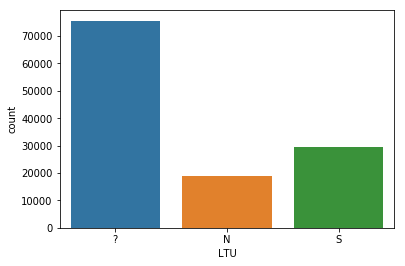

In [11]:
sns.countplot(x='LTU', data=df);

### DiasDesemprego

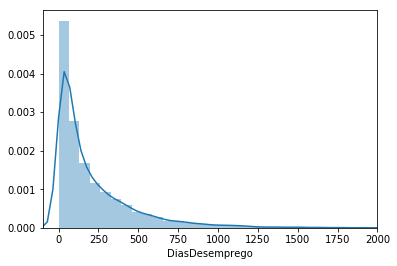

In [13]:
df_empregados = df[(df['Empregado']=='S')] 
# Só faz sentido mostrar aqueles que acabaram por ficar empregados
sns.distplot(df_empregados['DiasDesemprego'])
plt.xlim(-100, 2000);

In [14]:
#skewness e kurtosis
print("Skewness: %f" % df['DiasDesemprego'].skew())
print("Kurtosis: %f" % df['DiasDesemprego'].kurt())

Skewness: 34.710146
Kurtosis: 5270.179240


### Idade

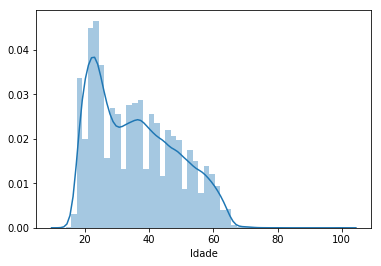

In [15]:
sns.distplot(df['Idade'].dropna())

***

## Análise Exploratória Multivariada

### DiasDesemprego-Sexo

Comparação das populações do sexo Masculino e Feminino em relação dos dias de desemprego.<br>
**Nota:** Deve-se filtar apenas as observações que resultaram em emprego pois só nesses casos sabemos ao certo quantos foram os dias que estiveram desempegados

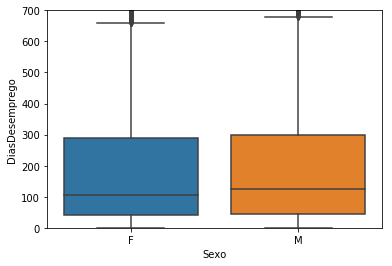

In [17]:
sns.boxplot(x='Sexo', y='DiasDesemprego', data=df_empregados)
plt.ylim(0, 700);

Olhando para a Mediana, aparentemente os utentes do sexo masculino ficam mais tempo desempregados...

In [18]:
print("Mediana 'DiasDesemprego' (Sexo M): {:.0f} dias".format(df_empregados[df.Sexo == 'M']['DiasDesemprego'].median()))
print("Mediana 'DiasDesemprego' (Sexo F): {:.0f} dias".format(df_empregados[df.Sexo == 'F']['DiasDesemprego'].median()))

Mediana 'DiasDesemprego' (Sexo M): 125 dias
Mediana 'DiasDesemprego' (Sexo F): 106 dias


### Sequências de eventos mais frequentes (TESTE)

In [44]:
listaEventos = [] # List de lists de eventos de cada utente [[Ut1_ev1, Ut1_ev2],[Ut2_ev1, Ut2_ev2]]
# Utiliza-se isto em vez de eventos em list única para os ngrams não incluirem eventos de dois utilizadores diferentes.

for ts, utente in listaUtentes.items():
    listaEventos.extend(utente.stringListOfEventsTypeDescription())

In [42]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

bcf = BigramCollocationFinder.from_documents(listaEventos)
#Metrics: http://www.nltk.org/_modules/nltk/metrics/association.html

In [43]:
bcf.score_ngrams(BigramAssocMeasures.student_t) # Retorna lista de ngrams ordenada desc. por score definido
#bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)

[(('Pedido de Emprego',
   'Intervenção | Outras Intervenções | INICIO PPE | INICIADO'),
  168.26858200107628),
 (('Mudança de Categoria | DESEMP NOVO EMPREGO - INDISPONÍVEL | DESEMPREGADO-NOVO EMPREGO',
   'Mudança de Categoria | DESEMPREGADO-NOVO EMPREGO | DESEMP NOVO EMPREGO - INDISPONÍVEL'),
  126.74446698569933),
 (('Anulacao | FALTA A CONVOCATÓRIA',
   'Intervenção | Outras Intervenções | FIM PPE | CONCLUIU'),
  124.69361187041027),
 (('Mudança de Categoria | DESEMPREGADO-NOVO EMPREGO | DESEMP NOVO EMPREGO - INDISPONÍVEL',
   'Mudança de Categoria | DESEMP NOVO EMPREGO - INDISPONÍVEL | DESEMPREGADO-NOVO EMPREGO'),
  110.96534376649883),
 (('Intervenção | Outras Intervenções | FIM PPE | CONCLUIU',
   'Pedido de Emprego'),
  107.95353988329443),
 (('Mudança de Categoria | OCUPADO | DESEMPREGADO-NOVO EMPREGO',
   'Mudança de Categoria | DESEMPREGADO-NOVO EMPREGO | OCUPADO'),
  107.90814623603477),
 (('Convocatória | OFERTA | APRESENTADO',
   'Apresentação | RECUSA DA ENTIDADE EMPREG

In [35]:
for k,v in bcf.nbest(BigramAssocMeasures.raw_freq, 5).ngram_fd.items():
    print(k,v)

AttributeError: 'list' object has no attribute 'ngram_fd'

### Fechar a ligação

In [82]:
connection.close()

<div class="alert alert-block alert-info"> 
- __[Shortcuts](https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/)__
- __[Markdown](http://datascience.ibm.com/blog/markdown-for-jupyter-notebooks-cheatsheet/)__